In [1]:
from datetime import datetime, timedelta
from collections import defaultdict
from time import time
import os
import matplotlib.pyplot as plt
import pandas as pd
import tweepy

In [2]:
#inputs
bearer_token = "AAAAAAAAAAAAAAAAAAAAAH4BlAEAAAAA3Dd4SGtdK%2FWbAqlEdIcXzoPB4%2BA%3DwDjEbymhTQgnmvHM8Vvetae79bgdBz1eyHWSyXZVqRnCCir1nA" #mpolo
limit = 2 #number of requests of `max_results` tweets each

In [3]:
#create paginator
client = tweepy.Client(bearer_token)
paginator = tweepy.Paginator( #TODO vedi come filtrare via tutti i tweet con media file
    method=client.search_recent_tweets,
    limit=limit,
    query=(
        '(context:131.825047692124442624 OR context:152.825047692124442624) ' #https://github.com/twitterdev/twitter-context-annotations
        '-is:retweet ' #TODO check and search doc for other usefull operators
        'lang:en'),
    end_time=datetime.utcnow()-timedelta(days=6), #go backwards starting from 6 days ago
    expansions=['author_id'], #TODO search doc for other usefull expansions
    max_results=100, #500 if academic research access
    tweet_fields=['public_metrics'], #TODO search doc for other usefull tweet fields
    user_fields=['public_metrics']) #TODO search doc for usefull user fields

#download tweets
data = defaultdict(list)
for response in paginator:
    for tweet, user in zip(response.data, response.includes['users']):
        if tweet.author_id == user.id: #some don't match for no reason
            data['text'] += [tweet.text]
            data['likes'] += [tweet.public_metrics['like_count']]
            data['followers'] += [user.public_metrics['followers_count']]

#save tweets
os.makedirs('debug_sets', exist_ok=True)
set_id = int(time() % 1e6) #unique for 11 days
pd.DataFrame(data).to_csv(f'debug_sets/{set_id}.csv', index=False)
set_id

409165

TODO `search_recent_tweets` is up to 7 days. To search further back, use [search_all_tweets](https://docs.tweepy.org/en/stable/client.html#tweepy.Client.search_all_tweets) instead (and add `start_time` parameter). But it needs the [academic research access](https://developer.twitter.com/en/docs/projects). It also increases the monthly cap from 500,000 to 10 million.

In [4]:
#load tweets
df = pd.read_csv(f'debug_sets/{set_id}.csv')
df.head(2)

,text,likes,followers
0,"Roasted chicken rice, char siew chicken rice, ...",0,1352
1,"Away from high blood pressure, diet is the mos...",0,0


/tmp/ipykernel_53939/2694474455.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  'avg_likes': df.groupby('foll_range').mean()['likes'],


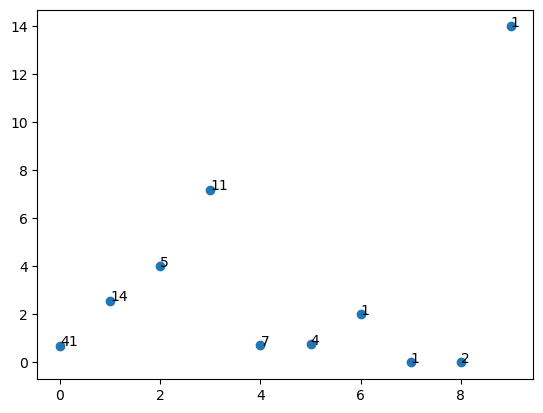

In [6]:
range_size = 100 #TODO adjust
max_ranges = 10 #TODO adjust

#group followers into ranges
df['foll_range'] = df['followers']//range_size
foll_ranges = pd.DataFrame({
    'avg_likes': df.groupby('foll_range').mean()['likes'],
    'tweets': df.groupby('foll_range').count()['likes']})
foll_ranges = foll_ranges.head(max_ranges)

#plot ranges vs average likes and annotate with number of tweets
x = foll_ranges.index
y = foll_ranges['avg_likes']
plt.scatter(x, y)
for i, tweets in enumerate(foll_ranges['tweets']):
    plt.annotate(tweets, (x[i], y[i]))

TODO con Dataset1.csv sembrava esserci buona correlazione e invece poi con altri dataset analoghi non più
quindi era solo un caso e sarebbe da provare con dataset molto più grande

TODO studia query [qua](https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/build-a-query)
    * continua a studiare link al tutorial "Building high-quality..." (da "Example queries & rules")
        * finora interessante solo:
            * link ad [annotations](https://developer.twitter.com/en/docs/twitter-api/annotations/overview)
            * In the new Twitter API (recent search and filtered stream), AND is applied before OR

verifica quello che dice chatGPT (i like invece credo li abbia solo il tweet originale):
"When you search for tweets using Tweepy, you will get the original tweet and any retweeted versions of that tweet as separate results. Retweets are considered to be separate tweets from the original, so you will receive multiple results for the same content if it has been retweeted multiple times. To avoid receiving duplicate results, you can use the .dedup() method of the Cursor object to remove duplicates. This will only return one result for each unique tweet, even if it has been retweeted multiple times."

inoltre like sempre a [zero se è retweet](https://twittercommunity.com/t/tweets-having-likes-more-than-zero-always-shows-zero-while-on-twitter-it-shows-more-than-zero-likes-it-only-shows-retweets-counts-accurate-please-tell-me-how-to-get-the-correct-like-count-as-well-i-am-using-twitter-v2-search-api/160840/4)